## Traininig of the High Level Feature classifier with TensorFlow/Keras

**4.0 Tensorflow/Keras, HLF classifier** This notebooks trains a dense neural network for the particle classifier using High Level Features. It uses TensorFlow/Keras on a single node. Spark is used in local mode to read the data.

To run this notebook we used the following configuration:
* *Software stack*: Spark 2.4.3, TensorFlow 1.13.1
* *Platform*: CentOS 7, Python 3.6
* *Spark* : local mode 

In [1]:
# pip install pyspark or use your favorite way to set Spark Home, here we use findspark
import findspark
findspark.init('/home/luca/Spark/spark-2.4.3-bin-hadoop2.7') #set path to SPARK_HOME

In [2]:
# Configure according to your environment
# Spark is used in local mode, just to fork data for HLF classifier (~ 300 MB)

from pyspark.sql import SparkSession
spark = SparkSession.builder \
        .appName("4.0c-Tensorflow-Keras HLF classifier") \
        .master("local[*]") \
        .config("spark.driver.memory","4g") \
        .getOrCreate()

In [3]:
# Check if Spark Session has been created correctly
spark

## Load train and test datasets via Spark

In [4]:
#PATH = "file:<full_path>/SparkDLTrigger/Data/"
PATH = "../Data/"

trainDF = spark.read.format('parquet')\
        .load(PATH + 'trainUndersampled_HLF_features')\
        .select(['HLF_input', 'encoded_label'])
        
testDF = spark.read.format('parquet')\
        .load(PATH + 'testUndersampled_HLF_features')\
        .select(['HLF_input', 'encoded_label'])

In [5]:
# Check the number of events in the train and test datasets

num_test = testDF.count()
num_train = trainDF.count()

print('There are {} events in the test dataset'.format(num_test))
print('There are {} events in the train dataset'.format(num_train))

There are 856090 events in the test dataset
There are 3426083 events in the train dataset


In [20]:
# Show the schema and a data sample of the test dataset
testDF.printSchema()
testDF.limit(5).toPandas()

root
 |-- HLF_input: vector (nullable = true)
 |-- encoded_label: vector (nullable = true)



,HLF_input,encoded_label
0,"[0.015150733133517018, 0.003511028294205839, 0...","(1.0, 0.0, 0.0)"
1,"[0.0, 0.003881822832783805, 0.7166341448458555...","(1.0, 0.0, 0.0)"
2,"[0.009639073600865505, 0.0010022659022912096, ...","(1.0, 0.0, 0.0)"
3,"[0.016354407625436572, 0.002108937905084598, 0...","(1.0, 0.0, 0.0)"
4,"[0.01925979125354152, 0.004603697276827594, 0....","(1.0, 0.0, 0.0)"


## Convert training and test datasets from Spark DataFrames to Numpy arrays

Now we will collect and convert the Spark DataFrame into numpy arrays in order to be able to feed them to TensorFlow/Keras.
This is a serial and slow operation, acceptable because we have only ~300 MB of Parquet data to process

In [10]:
import numpy as np

%time X = np.array(trainDF.select("HLF_input").collect()).reshape(num_train,14)
%time y = np.array(trainDF.select("encoded_label").collect()).reshape(num_train,3)

%time X_test = np.array(testDF.select("HLF_input").collect()).reshape(num_test,14)
%time y_test = np.array(testDF.select("encoded_label").collect()).reshape(num_test,3)

CPU times: user 23.5 s, sys: 260 ms, total: 23.8 s
Wall time: 27 s
CPU times: user 1min 5s, sys: 2.46 s, total: 1min 8s
Wall time: 1min 6s
CPU times: user 1min 27s, sys: 850 ms, total: 1min 28s
Wall time: 1min 34s
CPU times: user 4min 22s, sys: 10.5 s, total: 4min 33s
Wall time: 4min 23s


## Create the Keras model

In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

def create_model(nh_1, nh_2, nh_3):
    ## Create model
    model = Sequential()
    model.add(Dense(nh_1, input_shape=(14,), activation='relu'))
    model.add(Dense(nh_2, activation='relu'))
    model.add(Dense(nh_3, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    ## Compile model
    optimizer = 'Adam'
    loss = 'categorical_crossentropy'
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    
    return model

## Test the model

In [12]:
keras_model = create_model(50,20,10)

%time history = keras_model.fit(X, y, batch_size=32, epochs=10, validation_data=(X_test, y_test), verbose=1)

Train on 3426083 samples, validate on 856090 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
3426083/3426083 [==============================] - 101s 29us/sample - loss: 0.2662 - acc: 0.9016 - val_loss: 0.2442 - val_acc: 0.9096
Epoch 2/10
3426083/3426083 [==============================] - 101s 29us/sample - loss: 0.2407 - acc: 0.9109 - val_loss: 0.2354 - val_acc: 0.9130
Epoch 3/10
3426083/3426083 [==============================] - 101s 29us/sample - loss: 0.2357 - acc: 0.9128 - val_loss: 0.2335 - val_acc: 0.9139
Epoch 4/10
3426083/3426083 [==============================] - 101s 29us/sample - loss: 0.2330 - acc: 0.9139 - val_loss: 0.2285 - val_acc: 0.9158
Epoch 5/10
3426083/3426083 [==============================] - 101s 29us/sample - loss: 0.2300 - acc: 0.9150 - val_loss: 0.2289 - val_acc: 0.9155
Epoch 6/10
3426083/3426083 [==============================] - 101s 29us/sample - loss: 0.2281 - acc: 0.9157 - val_loss: 0.2333 - val_acc: 0.9138
Epoch 7/10
3426083/3426083 [=

<IPython.core.display.Javascript object>


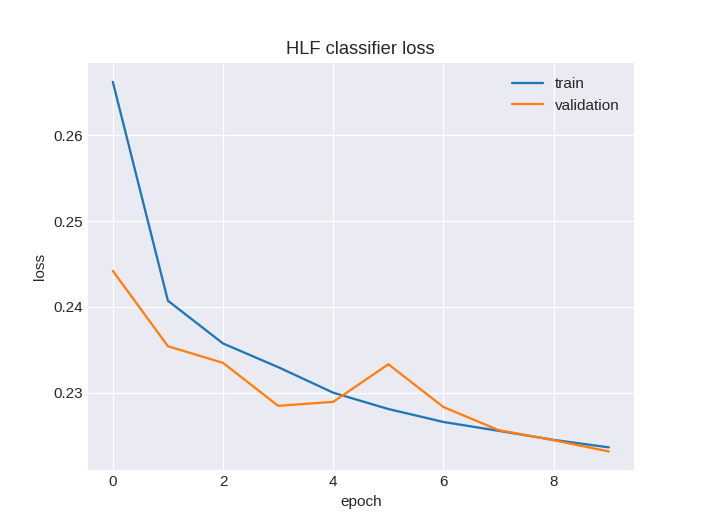

In [13]:
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
# Graph with loss vs. epoch

plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title("HLF classifier loss")
plt.show()

<IPython.core.display.Javascript object>


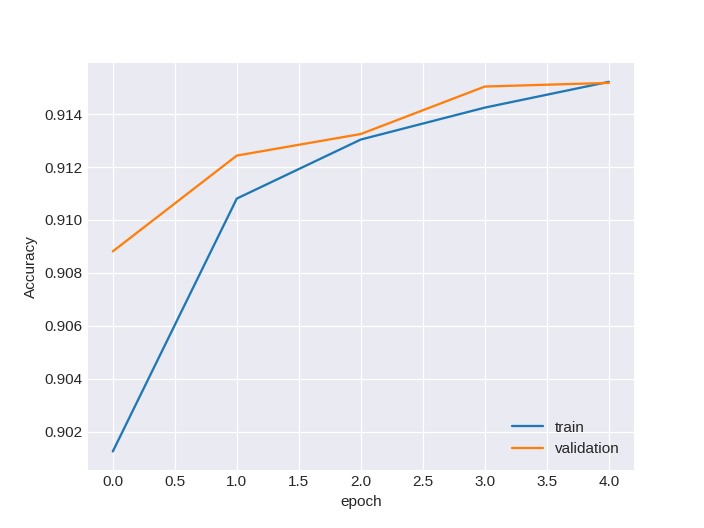

In [24]:
# Graph with accuracy vs. epoch
%matplotlib notebook
plt.figure()
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title("HLF classifier accuracy")
plt.show()

## Confusion Matrix

In [14]:
y_pred=history.model.predict(X_test)
y_true=y_test

In [15]:
from sklearn.metrics import accuracy_score

print('Accuracy of the HLF classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the HLF classifier: 0.9180


<IPython.core.display.Javascript object>


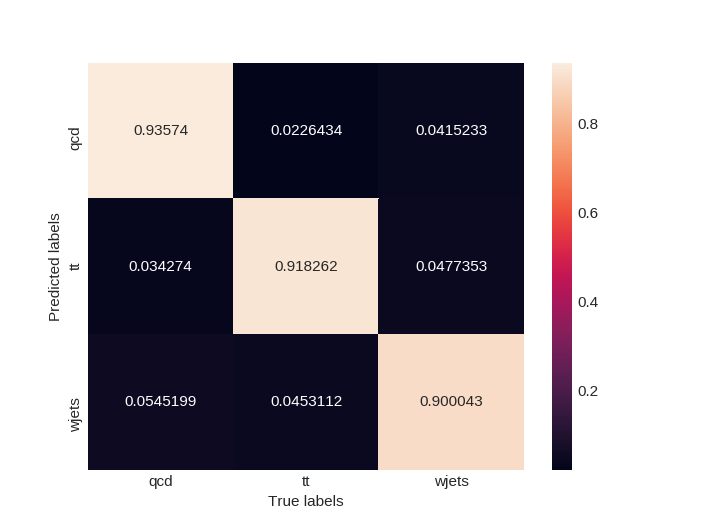

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(np.float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## ROC and AUC

In [17]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [18]:
# Dictionary containign ROC-AUC for the three classes 
roc_auc

{0: 0.9881524122781782, 1: 0.9857219578812669, 2: 0.9821801663729106}

<IPython.core.display.Javascript object>


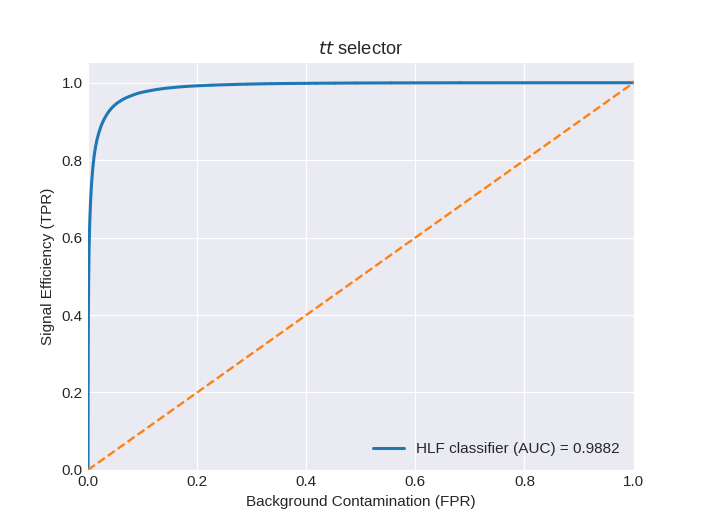

In [19]:
%matplotlib notebook

# Plot roc curve 
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')


plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, 
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()